# Intro to GraphNeuralNetworks.jl

*This notebook is a julia adaptation of the Pytorch Geometric tutorials that can be found [here](https://pytorch-geometric.readthedocs.io/en/latest/notes/colabs.html).*

Recently, deep learning on graphs has emerged to one of the hottest research fields in the deep learning community.
Here, **Graph Neural Networks (GNNs)** aim to generalize classical deep learning concepts to irregular structured data (in contrast to images or texts) and to enable neural networks to reason about objects and their relations.

This is done by following a simple **neural message passing scheme**, where node features $\mathbf{x}_i^{(\ell)}$ of all nodes $i \in \mathcal{V}$ in a graph $\mathcal{G} = (\mathcal{V}, \mathcal{E})$ are iteratively updated by aggregating localized information from their neighbors $\mathcal{N}(i)$:

$$
\mathbf{x}_i^{(\ell + 1)} = f^{(\ell + 1)}_{\theta} \left( \mathbf{x}_i^{(\ell)}, \left\{ \mathbf{x}_j^{(\ell)} : j \in \mathcal{N}(i) \right\} \right)
$$

This tutorial will introduce you to some fundamental concepts regarding deep learning on graphs via Graph Neural Networks based on the **[GraphNeuralNetworks.jl library](https://github.com/CarloLucibello/GraphNeuralNetworks.jl)**.
GraphNeuralNetworks.jl is an extension library to the popular deep learning framework [Flux.jl](https://fluxml.ai/Flux.jl/stable/), and consists of various methods and utilities to ease the implementation of Graph Neural Networks.

Let's first import the packages we need:

In [1]:
using Flux
using Flux: onecold, onehotbatch, logitcrossentropy
using MLDatasets
using LinearAlgebra, Random, Statistics
import GraphMakie
import CairoMakie as Makie
using Graphs
using GraphNeuralNetworks
ENV["DATADEPS_ALWAYS_ACCEPT"] = "true"  # don't ask for dataset download confirmation
Random.seed!(17); # for reproducibility

Following [Kipf et al. (2017)](https://arxiv.org/abs/1609.02907), let's dive into the world of GNNs by looking at a simple graph-structured example, the well-known [**Zachary's karate club network**](https://en.wikipedia.org/wiki/Zachary%27s_karate_club). This graph describes a social network of 34 members of a karate club and documents links between members who interacted outside the club. Here, we are interested in detecting communities that arise from the member's interaction.

GraphNeuralNetworks.jl provides utilities to convert [MLDatasets.jl](https://github.com/JuliaML/MLDatasets.jl)'s datasets to its own type:

In [2]:
dataset = MLDatasets.KarateClub()

dataset KarateClub:
  metadata  =>    Dict{String, Any} with 0 entries
  graphs    =>    1-element Vector{MLDatasets.Graph}

After initializing the `KarateClub` dataset, we first can inspect some of its properties.
For example, we can see that this dataset holds exactly **one graph**.
Furthermore, the graph holds exactly **4 classes**, which represent the community each node belongs to.


In [3]:
karate = dataset[1]

Graph:
  num_nodes   =>    34
  num_edges   =>    156
  edge_index  =>    ("156-element Vector{Int64}", "156-element Vector{Int64}")
  node_data   =>    (labels_clubs = "34-element Vector{Int64}", labels_comm = "34-element Vector{Int64}")
  edge_data   =>    nothing

In [4]:
karate.node_data.labels_comm


34-element Vector{Int64}:
 1
 1
 1
 1
 3
 3
 3
 1
 0
 1
 ⋮
 2
 0
 0
 2
 0
 0
 2
 0
 0

Now we convert the single-graph dataset to a `GNNGraph`. Moreover, we add a an array of node features, a **34-dimensional feature vector**  for each node which uniquely describes the members of the karate club. We also add a training mask selecting the nodes to be used for training in our semi-supervised node classification task.


In [5]:
# convert a MLDataset.jl's dataset to a GNNGraphs (or a collection of graphs)
g = mldataset2gnngraph(dataset)

x = zeros(Float32, g.num_nodes, g.num_nodes)
x[diagind(x)] .= 1

train_mask = [true, false, false, false, true, false, false, false, true,
    false, false, false, false, false, false, false, false, false, false, false,
    false, false, false, false, true, false, false, false, false, false,
    false, false, false, false]

labels = g.ndata.labels_comm
y = onehotbatch(labels, 0:3)

g = GNNGraph(g, ndata = (; x, y, train_mask))

GNNGraph:
  num_nodes: 34
  num_edges: 156
  ndata:
	y = 4×34 OneHotMatrix(::Vector{UInt32}) with eltype Bool
	train_mask = 34-element Vector{Bool}
	x = 34×34 Matrix{Float32}

Let's now look at the underlying graph in more detail:


In [6]:
# Gather some statistics about the graph.
println("Number of nodes: $(g.num_nodes)")
println("Number of edges: $(g.num_edges)")
println("Average node degree: $(g.num_edges / g.num_nodes)")
println("Number of training nodes: $(sum(g.ndata.train_mask))")
println("Training node label rate: $(mean(g.ndata.train_mask))")
# println("Has isolated nodes: $(has_isolated_nodes(g))")
println("Has self-loops: $(has_self_loops(g))")
println("Is undirected: $(is_bidirected(g))")

Number of nodes: 34
Number of edges: 156
Average node degree: 4.588235294117647
Number of training nodes: 4
Training node label rate: 0.11764705882352941


Has self-loops: false


Is undirected: true


Each graph in GraphNeuralNetworks.jl is represented by a  `GNNGraph` object, which holds all the information to describe its graph representation.
We can print the data object anytime via `print(g)` to receive a short summary about its attributes and their shapes.

The  `g` object holds 3 attributes:
- `g.ndata` contains node related information;
- `g.edata` holds edge-related information;
- `g.gdata`: this stores the global data, therefore neither node nor edge specific features.

These attributes are `NamedTuples` that can store multiple feature arrays: we can access a specific set of features e.g. `x`, with `g.ndata.x`.


In our task, `g.ndata.train_mask` describes for which nodes we already know their community assignments. In total, we are only aware of the ground-truth labels of 4 nodes (one for each community), and the task is to infer the community assignment for the remaining nodes.

The `g` object also provides some **utility functions** to infer some basic properties of the underlying graph.
For example, we can easily infer whether there exists isolated nodes in the graph (*i.e.* there exists no edge to any node), whether the graph contains self-loops (*i.e.*, $(v, v) \in \mathcal{E}$), or whether the graph is bidirected (*i.e.*, for each edge $(v, w) \in \mathcal{E}$ there also exists the edge $(w, v) \in \mathcal{E}$).

Let us now inspect the `edge_index` method:


In [7]:
edge_index(g)

([1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  34, 34, 34, 34, 34, 34, 34, 34, 34, 34], [2, 3, 4, 5, 6, 7, 8, 9, 11, 12  …  21, 23, 24, 27, 28, 29, 30, 31, 32, 33])

By printing `edge_index(g)`, we can understand how GraphNeuralNetworks.jl represents graph connectivity internally.
We can see that for each edge, `edge_index` holds a tuple of two node indices, where the first value describes the node index of the source node and the second value describes the node index of the destination node of an edge.

This representation is known as the **COO format (coordinate format)** commonly used for representing sparse matrices.
Instead of holding the adjacency information in a dense representation $\mathbf{A} \in \{ 0, 1 \}^{|\mathcal{V}| \times |\mathcal{V}|}$, GraphNeuralNetworks.jl represents graphs sparsely, which refers to only holding the coordinates/values for which entries in $\mathbf{A}$ are non-zero.

Importantly, GraphNeuralNetworks.jl does not distinguish between directed and undirected graphs, and treats undirected graphs as a special case of directed graphs in which reverse edges exist for every entry in the edge_index.

Since a `GNNGraph` is an `AbstractGraph` from the `Graphs.jl` library, it supports graph algorithms and visualization tools from the wider julia graph ecosystem:



## Implementing Graph Neural Networks

After learning about GraphNeuralNetworks.jl's data handling, it's time to implement our first Graph Neural Network!

For this, we will use on of the most simple GNN operators, the **GCN layer** ([Kipf et al. (2017)](https://arxiv.org/abs/1609.02907)), which is defined as

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \sum_{w \in \mathcal{N}(v) \, \cup \, \{ v \}} \frac{1}{c_{w,v}} \cdot \mathbf{x}_w^{(\ell)}
$$

where $\mathbf{W}^{(\ell + 1)}$ denotes a trainable weight matrix of shape `[num_output_features, num_input_features]` and $c_{w,v}$ refers to a fixed normalization coefficient for each edge.

GraphNeuralNetworks.jl implements this layer via `GCNConv`, which can be executed by passing in the node feature representation `x` and the COO graph connectivity representation `edge_index`.

With this, we are ready to create our first Graph Neural Network by defining our network architecture:


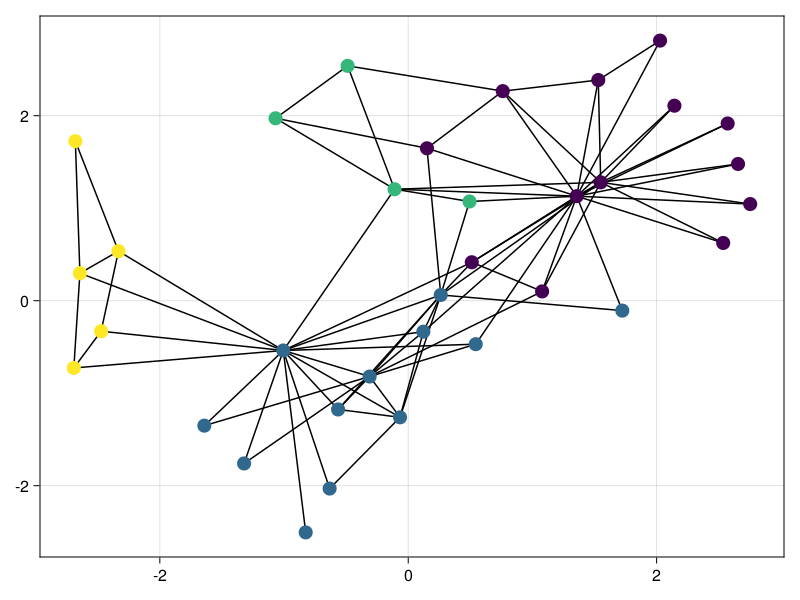

In [8]:
GraphMakie.graphplot(g |> to_unidirected, node_size = 20, node_color = labels,
                     arrow_show = false)

In [9]:
struct GCN
    layers::NamedTuple
end

Flux.@layer :expand GCN # provides parameter collection, gpu movement and more

function GCN(num_features, num_classes)
    layers = (conv1 = GCNConv(num_features => 4),
              conv2 = GCNConv(4 => 4),
              conv3 = GCNConv(4 => 2),
              classifier = Dense(2, num_classes))
    return GCN(layers)
end

function (gcn::GCN)(g::GNNGraph, x::AbstractMatrix)
    l = gcn.layers
    x = l.conv1(g, x)
    x = tanh.(x)
    x = l.conv2(g, x)
    x = tanh.(x)
    x = l.conv3(g, x)
    x = tanh.(x)  # Final GNN embedding space.
    out = l.classifier(x)
    # Apply a final (linear) classifier.
    return out, x
end


Here, we first initialize all of our building blocks in the constructor and define the computation flow of our network in the call method.
We first define and stack **three graph convolution layers**, which corresponds to aggregating 3-hop neighborhood information around each node (all nodes up to 3 "hops" away).
In addition, the `GCNConv` layers reduce the node feature dimensionality to $2$, *i.e.*, $34 \rightarrow 4 \rightarrow 4 \rightarrow 2$. Each `GCNConv` layer is enhanced by a `tanh` non-linearity.

After that, we apply a single linear transformation (`Flux.Dense` that acts as a classifier to map our nodes to 1 out of the 4 classes/communities.

We return both the output of the final classifier as well as the final node embeddings produced by our GNN.
We proceed to initialize our final model via `GCN()`, and printing our model produces a summary of all its used sub-modules.

### Embedding the Karate Club Network

Let's take a look at the node embeddings produced by our GNN.
Here, we pass in the initial node features `x` and the graph  information `g` to the model, and visualize its 2-dimensional embedding.


In [10]:
num_features = 34
num_classes = 4
gcn = GCN(num_features, num_classes)

GCN((conv1 = GCNConv(34 => 4), conv2 = GCNConv(4 => 4), conv3 = GCNConv(4 => 2), classifier = Dense(2 => 4)))

In [11]:
function visualize_embeddings(h; colors = nothing)
    xs = h[1, :] |> vec
    ys = h[2, :] |> vec
    Makie.scatter(xs, ys, color = labels, markersize = 20)
end

visualize_embeddings (generic function with 1 method)

In [12]:
_, h = gcn(g, g.ndata.x)

(Float32[0.02146625 0.025838671 … -0.0042725513 0.0056721903; 0.16082448 0.14679235 … -0.003681789 0.040167753; -0.09757348 -0.0888333 … 0.0020964658 -0.02435881; 0.114049815 0.106652185 … -0.004156831 0.028612293], Float32[-0.23871674 -0.21151944 … 0.0016090268 -0.05930534; -0.050135512 -0.05729834 … 0.008132701 -0.01309597])

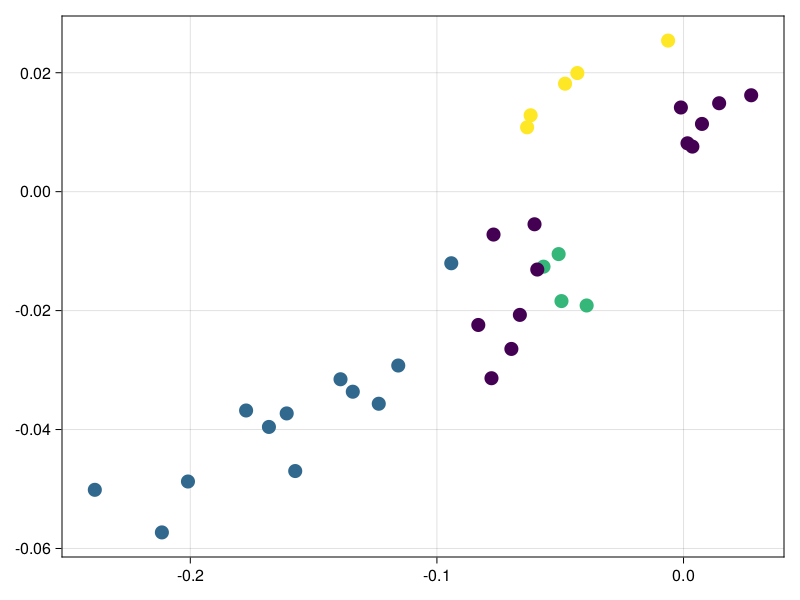

In [13]:
visualize_embeddings(h, colors = labels)

Remarkably, even before training the weights of our model, the model produces an embedding of nodes that closely resembles the community-structure of the graph.
Nodes of the same color (community) are already closely clustered together in the embedding space, although the weights of our model are initialized **completely at random** and we have not yet performed any training so far!
This leads to the conclusion that GNNs introduce a strong inductive bias, leading to similar embeddings for nodes that are close to each other in the input graph.

### Training on the Karate Club Network

But can we do better? Let's look at an example on how to train our network parameters based on the knowledge of the community assignments of 4 nodes in the graph (one for each community):

Since everything in our model is differentiable and parameterized, we can add some labels, train the model and observe how the embeddings react.
Here, we make use of a semi-supervised or transductive learning procedure: We simply train against one node per class, but are allowed to make use of the complete input graph data.

Training our model is very similar to any other Flux model.
In addition to defining our network architecture, we define a loss criterion (here, `logitcrossentropy`), and initialize a stochastic gradient optimizer (here, `Adam`).
After that, we perform multiple rounds of optimization, where each round consists of a forward and backward pass to compute the gradients of our model parameters w.r.t. to the loss derived from the forward pass.
If you are not new to Flux, this scheme should appear familiar to you.

Note that our semi-supervised learning scenario is achieved by the following line:
```
loss = logitcrossentropy(ŷ[:,train_mask], y[:,train_mask])
```
While we compute node embeddings for all of our nodes, we **only make use of the training nodes for computing the loss**.
Here, this is implemented by filtering the output of the classifier `out` and ground-truth labels `data.y` to only contain the nodes in the `train_mask`.

Let us now start training and see how our node embeddings evolve over time (best experienced by explicitly running the code):


In [14]:
model = GCN(num_features, num_classes)
opt_state = Flux.setup(AdamW(1e-2), model)
epochs = 10000

function report(epoch, loss)
    println((; epoch, loss))
end

report(0, Inf)
for epoch in 1:epochs
    loss, grads = Flux.withgradient(model) do model
        ŷ, emb = model(g, g.ndata.x)
        logitcrossentropy(ŷ[:, train_mask], y[:, train_mask])
    end

    Flux.update!(opt_state, model, grads[1])
    if epoch % 200 == 0
        report(epoch, loss)
    end
end

(epoch = 0, loss = Inf)


(epoch = 200, loss = 0.23355743f0)


(epoch = 400, loss = 0.121180125f0)


(epoch = 600, loss = 0.015979901f0)


(epoch = 800, loss = 0.006574087f0)


(epoch = 1000, loss = 0.0036216264f0)


(epoch = 1200, loss = 0.002299502f0)


(epoch = 1400, loss = 0.0015925727f0)


(epoch = 1600, loss = 0.001172607f0)


(epoch = 1800, loss = 0.0009049423f0)


(epoch = 2000, loss = 0.0007246111f0)


(epoch = 2200, loss = 0.000597144f0)


(epoch = 2400, loss = 0.0005032007f0)


(epoch = 2600, loss = 0.00043123285f0)


(epoch = 2800, loss = 0.0003746021f0)


(epoch = 3000, loss = 0.00032866356f0)


(epoch = 3200, loss = 0.00029070757f0)


(epoch = 3400, loss = 0.00025867915f0)


(epoch = 3600, loss = 0.00023138715f0)


(epoch = 3800, loss = 0.0002077891f0)


(epoch = 4000, loss = 0.00018708072f0)


(epoch = 4200, loss = 0.00016890466f0)


(epoch = 4400, loss = 0.00015278431f0)


(epoch = 4600, loss = 0.00013848138f0)


(epoch = 4800, loss = 0.00012560855f0)


(epoch = 5000, loss = 0.0001140765f0)


(epoch = 5200, loss = 0.00010373627f0)


(epoch = 5400, loss = 9.43495f-5)


(epoch = 5600, loss = 8.585665f-5)


(epoch = 5800, loss = 7.8168305f-5)


(epoch = 6000, loss = 7.1165305f-5)


(epoch = 6200, loss = 6.481786f-5)


(epoch = 6400, loss = 5.906639f-5)


(epoch = 6600, loss = 5.379169f-5)


(epoch = 6800, loss = 4.899377f-5)


(epoch = 7000, loss = 4.4613043f-5)


(epoch = 7200, loss = 4.0589908f-5)


(epoch = 7400, loss = 3.6983973f-5)


(epoch = 7600, loss = 3.3646236f-5)


(epoch = 7800, loss = 3.06065f-5)


(epoch = 8000, loss = 2.7864771f-5)


(epoch = 8200, loss = 2.530184f-5)


(epoch = 8400, loss = 2.3066721f-5)


(epoch = 8600, loss = 2.098061f-5)


(epoch = 8800, loss = 1.9043497f-5)


(epoch = 9000, loss = 1.7314995f-5)


(epoch = 9200, loss = 1.5735499f-5)


(epoch = 9400, loss = 1.4305009f-5)


(epoch = 9600, loss = 1.29341215f-5)


(epoch = 9800, loss = 1.1742044f-5)


(epoch = 10000, loss = 1.0698975f-5)


In [15]:
ŷ, emb_final = model(g, g.ndata.x)

(Float32[1.2480338 1.2870314 … 12.100139 12.070936; 13.099802 13.113997 … -0.24358645 -0.20657605; 1.0239704 0.984712 … -12.734783 -12.697578; -12.253804 -12.265931 … 0.30469286 0.26988137], Float32[0.9960584 0.99404913 … -0.9997268 -0.9942645; 0.9955566 0.9999856 … 0.9999097 0.9999764])

In [16]:
# train accuracy
mean(onecold(ŷ[:, train_mask]) .== onecold(y[:, train_mask]))

1.0

In [17]:
# test accuracy
mean(onecold(ŷ[:, .!train_mask]) .== onecold(y[:, .!train_mask]))

0.8

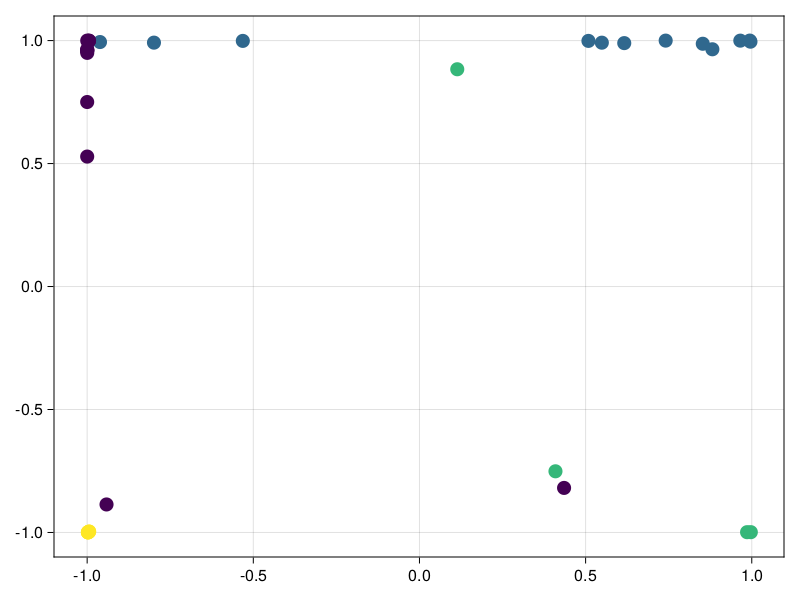

In [18]:
visualize_embeddings(emb_final, colors = labels)


As one can see, our 3-layer GCN model manages to linearly separating the communities and classifying most of the nodes correctly.

Furthermore, we did this all with a few lines of code, thanks to the GraphNeuralNetworks.jl which helped us out with data handling and GNN implementations.